In [1]:
import numpy  as np
import matplotlib.pyplot as plt

from utils import *

from hcipy import *

from processing import *

%load_ext autoreload
%autoreload 2

## Input Parameters

Set the telescope and atmospheric parameters:

In [2]:
# Telescope setup
pupil_diameter = 3.048                                 # (meter)
f_number = 13                                          # effective focal ratio
filter_name = 'V'                                      # filter name
wavelength = filters[filter_name]['lambda_eff'] * 1e-6 # (meter)
grid_size = 256                                        # the number of pixels per dimension

# Generating the atmosphere
seeing = 1.75
outer_scale = 40  # (meter)
velocity = 20     # (m/s)

Set resolution elements and exposure parameters:

In [3]:
# Exposure time & total number of exposures
exposure_total = 100
exposure_time = 0.01  # (seconds)

# Setting focal grid resolution elements
q = 4       # the number of pixels per resolution element (= lambda f / D)
nairy = 100 # the spatial extent of the grid in radius in resolution elements (= lambda f / D)

Set detector parameters:

In [4]:
# Noisy detector setup
dark_current_rate = 0 
read_noise = 0
flat_field = 0
photon_noise = True

Add in primary and companion parameters:

In [5]:
# Primary parameters
mag = 5                      # Vega magnitude in the band of interest
stokes_vector= [1.,0.,0.,0.] # I, Q, U, V

# Companion parameters
contrast = 0.9
stokes_ps = [1.,0.,0.,0.]   #  I, Q, U, V
angular_separation= 3        # (Lambda/D)

Set parameters for processing and speckle analysis:

In [6]:
plate_scale = wavelength / (pupil_diameter * q) * 206265.

# setting subframe size to be 2.5x the seeing disk FWHM
spix = int(2.5 * (seeing/plate_scale)) 

# setting gsigma to be 10% of the seeing disk FWHM
sigma = 0.1 * (seeing/plate_scale)

#setting the supergaussian HWHM to be 90% of spix HWHM
sg_hwhm = int(0.9 * (spix/2))

#order of supergaussian window , larger m --> wider window, too small--> blurring in FTs
sg_m = 4


In [7]:
# Function Processing - see processing.py for more detail
# ims           - input image array
# gsigma        - std deviation for the Gaussian kernel
# subframe_size - final image size in pixels
# HWHM          - half-wavelength at half maximum for supergaussian window
# m             - order of supergaussian window


#spix    = 550   # subframe size
#sigma   = 20    # gsigma 
#sg_hwhm = 100   # HWHM for sg window
#sg_m    = 4     # m ; order of sg window

## Telescope Setup
Starting with the Magellan pupil (scaled to 3.048 m) till we get a description of the Shane pupil 

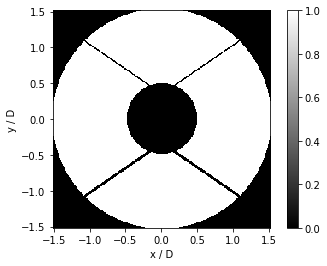

In [8]:
collecting_area = np.pi * (3.048**2 - 0.9779**2)
effective_focal_length = pupil_diameter * f_number # (meter)

# Generating the pupil grid
pupil_grid = make_pupil_grid(grid_size, diameter=pupil_diameter)

# Adjust spiders to represent Shane pupil
telescope_pupil_generator = make_lick_aperture()
telescope_pupil = telescope_pupil_generator(pupil_grid)

im = imshow_field(telescope_pupil, cmap='gray', )
plt.colorbar()
plt.xlabel('x / D')
plt.ylabel('y / D')
plt.show()


## Setting Up the Atmosphere
seeing estimated from the following source: 
https://mthamilton.ucolick.org/techdocs/MH_weather/obstats/avg_seeing.html

In [9]:
fried_parameter = seeing_to_fried_parameter(seeing, wavelength)
                             
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)

tau0 = 0.314 * fried_parameter/velocity

print('r0   = {0:.1f}cm'.format(fried_parameter * 100))
print('L0   = {0:.1f}m'.format(outer_scale))
print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
print('v    = {0:.1f}m/s'.format(velocity))

r0   = 6.3cm
L0   = 40.0m
tau0 = 1.0ms
v    = 20.0m/s


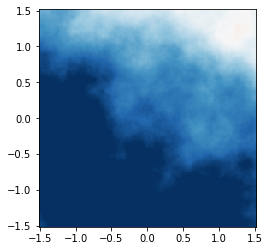

In [10]:
# Generating phase screens
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

phase_screen_phase = layer.phase_for(wavelength) # (radian)
phase_screen_opd = phase_screen_phase * (wavelength / (2 * np.pi)) * 1e6

imshow_field(phase_screen_opd, vmin=-2*np.pi, vmax=2*np.pi, cmap='RdBu')

In [11]:
# Propagating to focal plane
focal_grid = make_focal_grid(q=q, 
                             num_airy=nairy,
                             pupil_diameter=pupil_diameter,
                             focal_length = effective_focal_length,
                             reference_wavelength=wavelength)

prop = FraunhoferPropagator(pupil_grid, focal_grid, 
                            focal_length=effective_focal_length)

### Simulating Image Data

In [12]:
pupil_wavefront = Wavefront(telescope_pupil, wavelength,
                            input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag,filter_name,collecting_area,) #In (photons/s)


wf_planet = Wavefront(telescope_pupil*np.exp(4j*np.pi*pupil_grid.x*angular_separation/pupil_diameter),
                      wavelength,
                      input_stokes_vector=stokes_ps)
wf_planet.total_power = contrast * number_of_photons(mag,filter_name,collecting_area,) #In (photons/s)

In [13]:
detector = NoisyDetector(focal_grid, dark_current_rate=dark_current_rate, read_noise=read_noise, flat_field=flat_field, include_photon_noise=photon_noise)
ims = []
layer.t = exposure_time
for i in range(exposure_total):
    layer.t+=exposure_time
    detector.integrate(prop((layer(pupil_wavefront))),exposure_time)
    detector.integrate(prop((layer(wf_planet))),exposure_time)   
    image_comb = detector.read_out()
    ims.append(image_comb)

In [14]:
npix = int(np.sqrt(np.prod(image_comb.shape)))
ims_out = []

for i in range(len(ims)):
    im = ims[i]
    im_out = im.copy().reshape([npix,npix])
    ims_out.append(np.array(im_out))
ims_out_a = np.array(ims_out)

### Image Processing
includes preprocessing, taking FTs, power spectra, and ACFs

In [15]:
# Function Parameters - see processing.py for more detail
# ims           - input image array
# ims_ft        - input FT array
# ims_ps        - input average PS
# scaling       - determines radial cutoff (fcut) for PS


ims_p = image_preprocessing(ims_out_a, sigma, spix)
#              parameters: (ims, gsigma, subframe_size)

FT = fourier_transform(ims_p, sg_hwhm, sg_m)
#              parameters: (ims, HWHM, m)

PS, PS_avg = power_spectrum(FT, q, wavelength, pupil_diameter)
#              parameters: (ims_ft, q, wavelength, pupil_diameter, scaling=1.)

ACF = generate_ACF(PS_avg)
#              parameters: (ims_ps)

Text(0, 0.5, 'Mean')

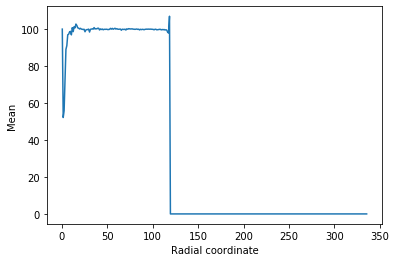

In [16]:
from radial_profile import radial_data

rad_stats = radial_data(PS_avg)
plt.figure()
plt.plot(rad_stats.r, rad_stats.mean)
plt.xlabel('Radial coordinate')
plt.ylabel('Mean')

### Final Image, PS, and ACF

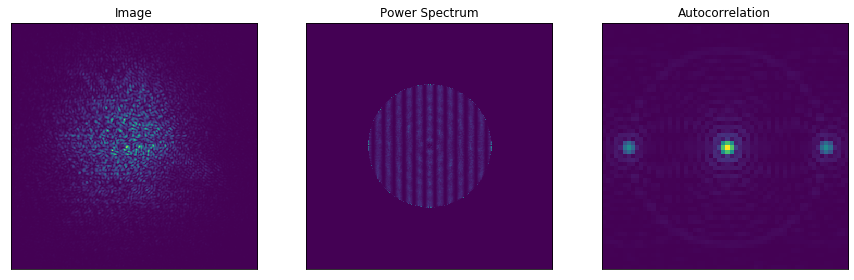

In [17]:
# Image, PS, and ACF plots
f = plt.figure(figsize=(15,5))
ax=f.add_subplot(131)
plt.imshow(ims_p[0])
ax.set_yticks([])
ax.set_xticks([])
plt.title('Image')

ax = f.add_subplot(132)
plt.title('Power Spectrum')
plt.imshow(np.abs(PS_avg))
ax.set_yticks([])
ax.set_xticks([])

fsub = 30

ax=f.add_subplot(133)
plt.imshow(np.abs(ACF)[int(spix/2)-fsub:int(spix/2)+fsub,int(spix/2)-fsub:int(spix/2)+fsub])

ax.set_yticks([])
ax.set_xticks([])
plt.title('Autocorrelation')
plt.show()

## Speckle Contrast Curve

/Users/Nicole/Desktop/specklepol-master (updated)/processing.py:189: RuntimeWarning: invalid value encountered in sqrt
  ACF_cc = -2.5 * np.log10((1. - np.sqrt(1. - (2 * (sigma * rad_ACF.std)) ** 2)) / (2 * (sigma * rad_ACF.std)))


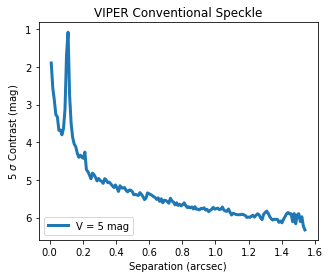

In [18]:
ACF_contrast(ACF, q, wavelength, pupil_diameter, mag)
# parameters: (ACF, q, wavelength, pupil_diameter, magnitude, sigma=5, figure_size=(5,4))